# Noteboook for High Frequency SSVEP 
Jimmy Pulido Arias 

In [13]:
# Import libraries
import os
import sys
import numpy as np 
import seaborn  as sns 
import pandas as pd 
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)
import mne
%matplotlib inline
import matplotlib.pyplot as plt

## Read Data 

In [23]:
from eegtools.eegprocessor import EEGProcessor
from eegtools.fbcca import FBCCA
from eegtools.psd import PSDAnalyzer

stimuli_ids = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11"] 
frequencies = [32.5, 34.0, 31.5, 35.5, 34.5, 30.0, 33.5, 30.5, 32.0, 35.0, 31.0, 33.0]

In [25]:
stimuli_time = 5
delay = [0,0,0]

file_names = ["jimmy_diff_feedback_8step_2shover.bdf"]

eegdf_list = []
for file_name, d in zip(file_names, delay): 

    eegdf = EEGProcessor(path=file_name, stimuli_ids=stimuli_ids, 
                root="/home/cnelab-workstation/jimmy/HFSSVEP_Online/Data/", 
                stimuli_time=5, delay=d)
    eegdf.preprocess_eeg(pick_channels=EEGProcessor._channels_o, l_freq=0.1, h_freq=200, ch_reference='Cz')
    eegdf.get_epochs(tmin=-7, tmax=12)
    eegdf_list.append(eegdf.epochs)

Extracting EDF parameters from /home/cnelab-workstation/jimmy/HFSSVEP_Online/Data/jimmy_diff_feedback_8step_2shover.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 697343  =      0.000 ...  1361.998 secs...


FileNotFoundError: [Errno 2] No such file or directory: '/home/cnelab-workstation/jimmy/HFSSVEP_Online/Data/jimmy_diff_feedback_8step_2shover.csv'

In [16]:
epochs_big = mne.concatenate_epochs(eegdf_list)
epochs_big

Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)


/tmp/ipykernel_682780/2028068477.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_big = mne.concatenate_epochs(eegdf_list)


Number of events,120
Events,0: 101: 1010: 1011: 102: 103: 104: 105: 106: 107: 108: 109: 10
Time range,-7.000 – 12.000 s
Baseline,0.000 – 0.000 s


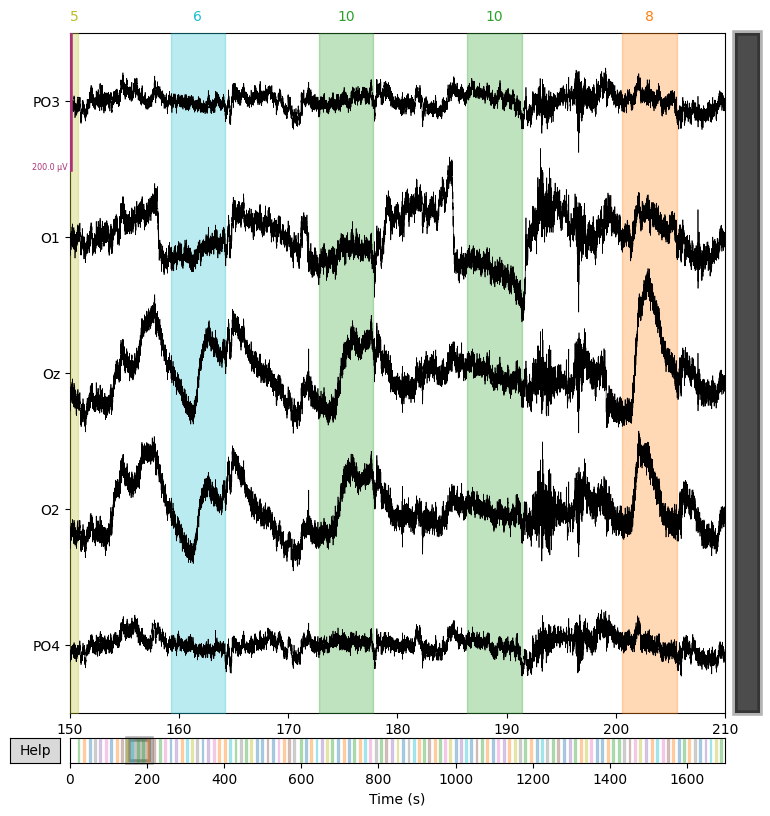

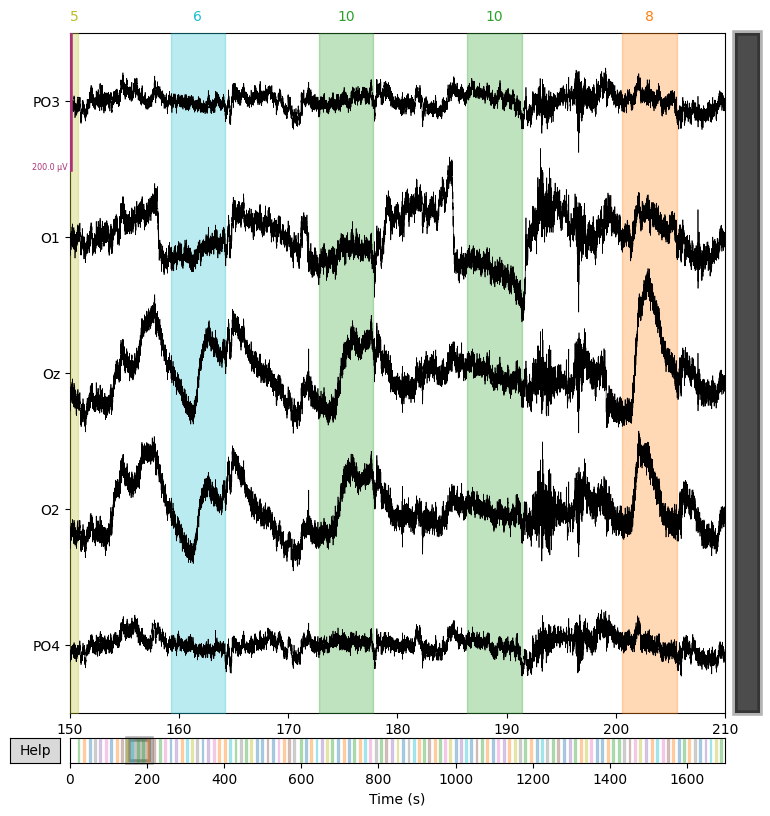

In [17]:
eegdf.raw.plot(start=150, duration=60, scalings=0.0001)

# PSD

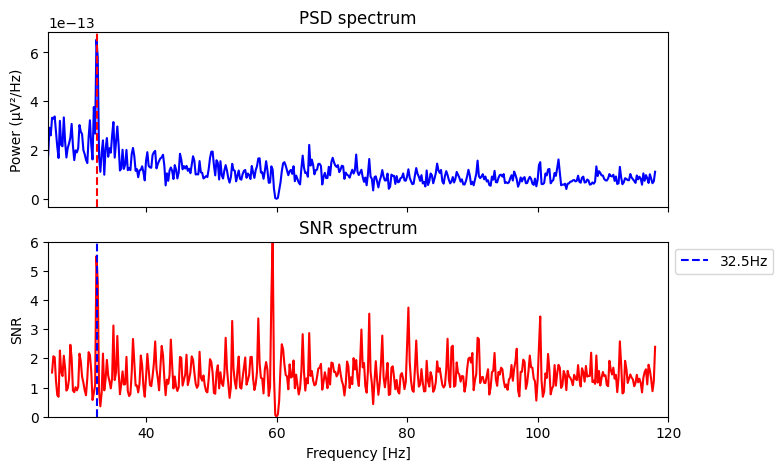

In [18]:
analyzer = PSDAnalyzer(frequencies=frequencies)
psds, freqs, snrs = analyzer.calculate_psd_snr(eegdf.epochs["0"], frequencies)
analyzer.plot_psd_snr(psds, freqs, snrs, frequencies[0], "file_name")

In [19]:
n_seconds = 3
time = np.linspace(0, n_seconds,int(n_seconds * 512) ,
                   endpoint=False)[np.newaxis, :]

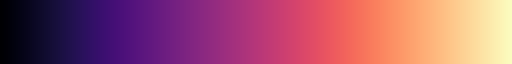

In [20]:
sns.color_palette("magma", as_cmap=True)


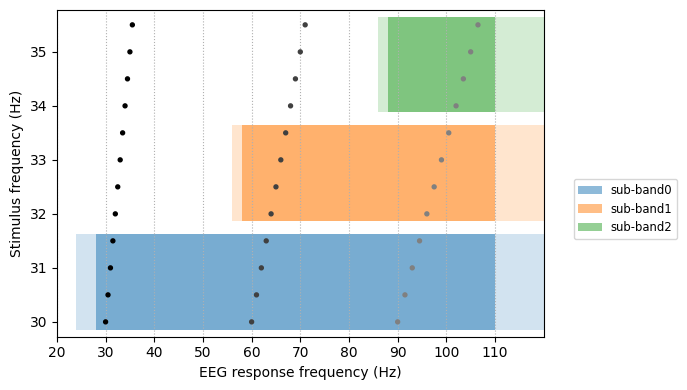

In [21]:
filterbank = [
              [(28, 110), (24, 120)], 
              [(58, 110), (56, 120)],
              [(88, 110), (86, 120)],              ]


f, ax = plt.subplots(1, figsize=(7, 4))
for i, _band in enumerate(filterbank):
    ax.axvspan(ymin=i / len(filterbank) + .02,
               ymax=(i + 1) / len(filterbank) - .02,
               xmin=filterbank[i][1][0], xmax=filterbank[i][1][1],
               alpha=0.2, facecolor=f"C{i}")
    ax.axvspan(ymin=i / len(filterbank) + .02,
               ymax=(i + 1) / len(filterbank) - .02,
               xmin=filterbank[i][0][0], xmax=filterbank[i][0][1],
               alpha=0.5, label=f"sub-band{i}", facecolor=f"C{i}")

for f in frequencies:
    colors = np.ones((3, 4))
    colors[:, :3] = np.linspace(0, .5, 3)[:, None]
    ax.scatter(f * np.arange(1, 4), [f] * 3, c=colors, s=8, zorder=100)

ax.set_ylabel("Stimulus frequency (Hz)")
ax.set_xlabel("EEG response frequency (Hz)")
ax.set_xlim([20, 120])
ax.set_xticks(np.arange(20, 120, 10))
ax.grid(True, ls=":", axis="x")
ax.legend(bbox_to_anchor=(1.05, .5), fontsize="small")
plt.tight_layout()
plt.show()

# FBCCA

In [22]:
# FBCCA individual
import warnings
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed


def process_window(w, fs, samples, eegdf, frequencies, fbcca_model):
        print(w)
        n_win = w
        n_samples = int(fs * n_win) 
        p = int(samples / n_samples)
        one_epoch = eegdf.epochs.copy()
        y, y_pred = [], [] 
        Rho = [] 
        for i in range(12): 
            X = one_epoch["{}".format(i)].get_data()
            X = X[:,:,:n_samples]
            print("{}: =============================================".format(i))
            pred, rho = fbcca_model.fbcca(X, frequencies, fs)
            
            y += [i] * len(pred)
            y_pred += pred
            Rho.append(rho)
        return w, y, y_pred, Rho

def run_fbcca_analysis(win_sizes, fs, eegdf, frequencies, fbcca_model, win=5):
    warnings.filterwarnings('ignore') 
    eegdf.epochs.resample(sfreq=512.0)
    samples = fs * win
    results = {}

    num_cores = multiprocessing.cpu_count()
    with ProcessPoolExecutor(max_workers=num_cores) as executor:
        futures = [executor.submit(process_window, w, fs, samples, eegdf, frequencies, fbcca_model) for w in win_sizes]
        
        for future in as_completed(futures):
            w, y, y_pred, Rho = future.result()
            results[w] = {
                "y": y,
                "y_pred": y_pred,
                "Rho": Rho
            }
    
    return results

In [12]:
from sklearn.metrics import f1_score


fbcca_model = FBCCA(num_harms=1, num_fbs=1, a=1.25, b=0.25)


window_sizes = [2.0 ]
win_overlap =  [0.5]

fs = 512

data_window_sizes = { }

epochs_big.resample(sfreq=512.0)

for w, wo in zip(window_sizes, win_overlap): 
    win_top = np.round(np.arange(w, 20 + wo, wo),2)
    win_bottom = np.round(np.arange(0.0, 20 - w + wo , wo),2)

    assert(len(win_top) == len(win_bottom))

    f_rho = {"frequency" : [], "win_top" : [], "rho" : [], "accuracy" : []}

    one_epoch = epochs_big.copy()


    def process_window_pair(args):
        b, t, fs, one_epoch, frequencies, fbcca_model = args
        print(t)
        i_top = int(fs*t)
        i_bottom = int(fs*b)
        results = []
        
        for i in range(12):
            X = one_epoch[f"{i}"].get_data(copy=True)
            X = X[:,:,i_bottom:i_top]
            print("{}-{}: =============================================".format(t,i))
            pred, rho = fbcca_model.fbcca(X, frequencies, fs)
            y = [i]*len(pred)
            #rho = np.stack(rho, axis=0)
            
            for j in rho:
                results.append({
                    "frequency": frequencies[i],
                    "win_top": t,
                    "rho": j,
                    "accuracy": f1_score(y, pred, average="weighted")
                })
                
        return results

    num_cores = 4 # multiprocessing.cpu_count()
    window_pairs = [(b, t, fs, one_epoch, frequencies, fbcca_model) 
                   for b, t in zip(win_bottom, win_top)]
    
    with ProcessPoolExecutor(max_workers=num_cores) as executor:
        all_results = list(executor.map(process_window_pair, window_pairs))
    
    # Flatten results and populate f_rho dictionary
    for window_results in all_results:
        for result in window_results:
            f_rho["frequency"].append(result["frequency"])
            f_rho["win_top"].append(result["win_top"]) 
            f_rho["rho"].append(result["rho"])
            f_rho["accuracy"].append(result["accuracy"])

    data_window_sizes[f'{w}:{wo}'] = f_rho

2.0
2.0-0: =============================================
2.5
2.5-0: =============================================
3.0
3.0-0: =============================================
3.5
3.5-0: =============================================
2.5-1: =============================================
2.0-1: =============================================
3.0-1: =============================================
3.5-1: =============================================
2.5-2: =============================================
2.0-2: =============================================
3.5-2: =============================================
2.5-3: =============================================
3.0-2: =============================================
2.0-3: =============================================
2.5-4: =============================================
3.0-3: =============================================
3.5-3: =============================================
2.0-4: =============================================
2.5-5: =======================

In [143]:
df_result = pd.DataFrame(data_window_sizes["2.0:0.5"])
df_result = df_result[df_result["win_top"] < 17]

df_result["rho_mean"] =np.stack(df_result["rho"].to_numpy()).mean(axis=1)

df_result["rho_norm"] = np.linalg.norm(np.stack(df_result["rho"], axis=0), axis=1)

df_result["rho_max"] = np.stack(df_result["rho"].to_numpy()).max(axis=1)

df_result["rho_std"] = np.std(np.stack(df_result["rho"], axis=0), axis=1)

df_result["rho_max_2ndmax"] = df_result["rho_max"] - np.partition(np.stack(df_result["rho"].to_numpy()), -2, axis=1)[:,-2]


df_result["rho_1"] = np.stack(df_result["rho"].to_numpy())[:,0]
df_result["rho_2"] = np.stack(df_result["rho"].to_numpy())[:,1]
df_result["rho_3"] = np.stack(df_result["rho"].to_numpy())[:,2]
df_result["rho_4"] = np.stack(df_result["rho"].to_numpy())[:,3]

In [1]:

sns.set_style('ticks')
for w, wo in zip(window_sizes, win_overlap): 

    fig, ax = plt.subplots()

    ax2 = ax.twinx()
    # the size of A4 paper
    fig.set_size_inches(11.7, 8.27)
    sns.lineplot(data=df_result, x="win_top", y="accuracy",color="g", ax=ax,label = 'accuracy').set_title(f'CCA Rho value / window {w}s, overlap {w-wo}')
    sns.lineplot(df_result, x="win_top", y="rho_max_2ndmax", ax=ax2, label = 'Rho Correlation')
    #plt.xticks(ticks=np.arange(0, 9, 1))

    ax.axvline(x=7, label="Instruction to gaze", color='r', linestyle='--')
    ax.axvline(x=12, label="Instruction to stop gazing", color='b', linestyle='--')

    ax.legend(bbox_to_anchor=(0.8, 1), loc='upper left')
    ax2.legend(bbox_to_anchor=(0.8, 0.9), loc='upper left')
    fig.show()

NameError: name 'sns' is not defined

In [202]:

df_result.loc[df_result["accuracy"]>=0.5,"Gaze"] = "Gazing"
df_result.loc[df_result["accuracy"]<0.5,"Gaze"] = "Not Gazing"
#df_result.loc[df_result["accuracy"]>,"Gaze"] = "Not Gazing"

In [184]:
df_result.loc[df_result["win_top"]<=12,"Gaze"] = "Not Gazing"
df_result.loc[df_result["win_top"]>=7,"Gaze"] = "Gazing"

df_result.loc[df_result["win_top"]>12,"Gaze"] = "Not Gazing"

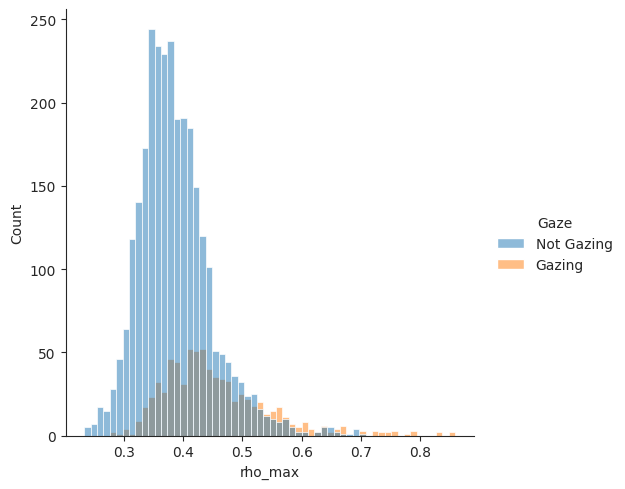

In [178]:
sns.displot(df_result, x="rho_max", hue="Gaze")

<Axes: xlabel='accuracy', ylabel='rho_norm'>

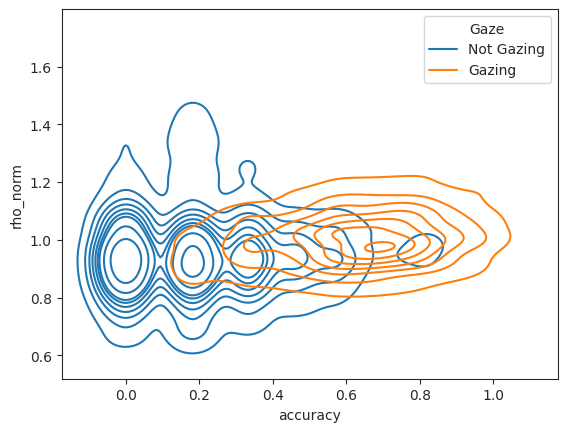

In [74]:
sns.kdeplot(df_result, x="accuracy", y = "rho_norm", hue="Gaze", fill=False)


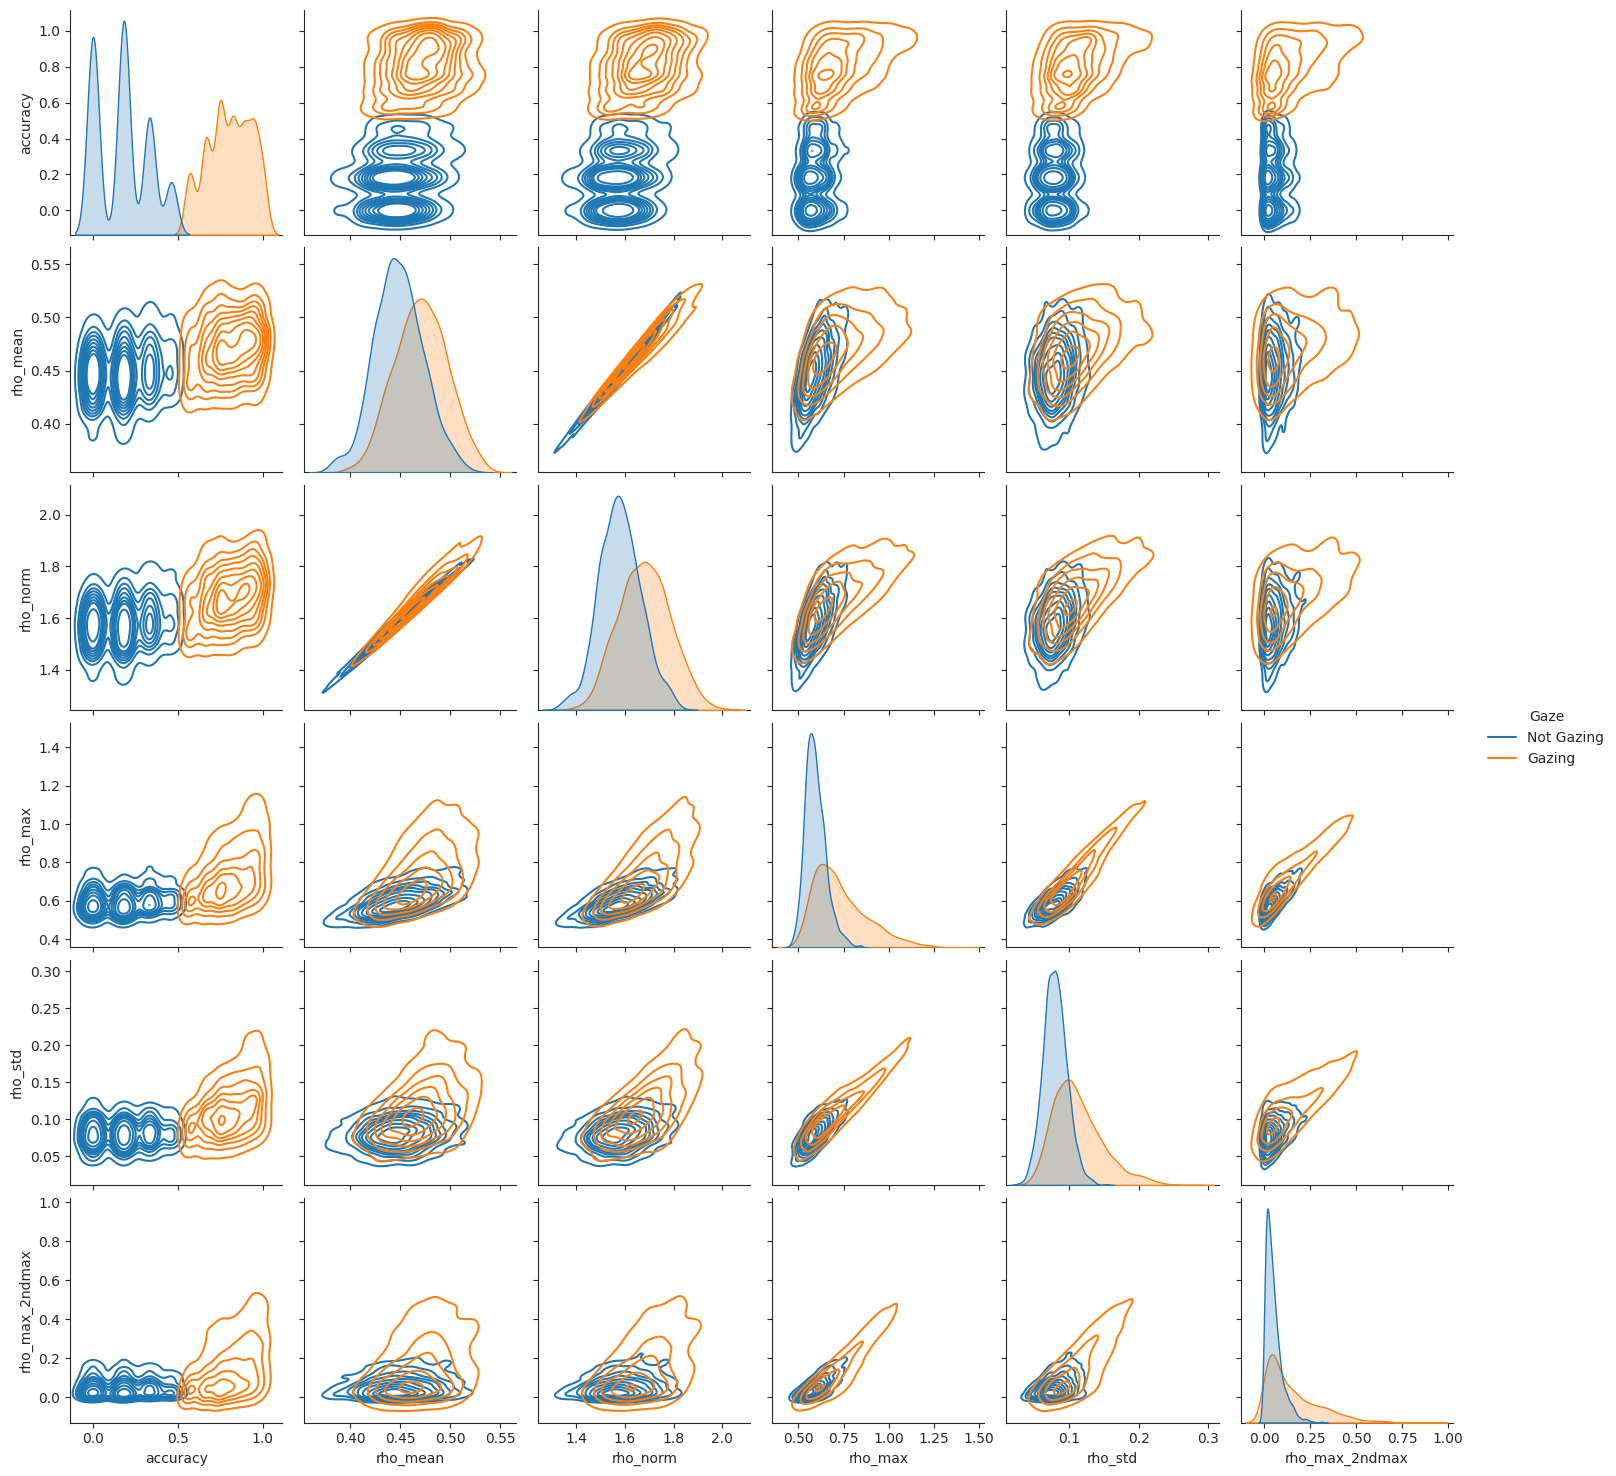

In [306]:
sns.pairplot(df_result[["accuracy","rho_mean","rho_norm", "rho_max", "rho_std", "rho_max_2ndmax", "Gaze"]],  hue="Gaze", kind="kde")


39960

In [210]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC

X = df_result[["rho_mean","rho_norm", "rho_max", "rho_std", "rho_max_2ndmax", 
                                                                   "rho_1", "rho_2", "rho_3", "rho_4"]]
y = df_result['Gaze']
# create loocv procedure
cv = LeaveOneOut()

kf = KFold(10)
clf = SVC(kernel='rbf', random_state=42)

scores = cross_val_score(clf, X, y, scoring='f1_macro', cv=kf, n_jobs=-1)

print('Accuracy: %.10f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.4313218647 (0.090)


In [209]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

for w, wo in zip(window_sizes, win_overlap): 
    X_train, X_test, y_train, y_test = train_test_split(df_result[["rho_mean","rho_norm", "rho_max", "rho_std", "rho_max_2ndmax", 
                                                                   "rho_1", "rho_2", "rho_3", "rho_4"]], 
                                                        df_result['Gaze'], test_size=0.30, 
                                                        random_state=35)


    #logmodel = SVC(kernel="rbf")
    logmodel = LogisticRegression()
    logmodel.fit(X_train,y_train)
    predictions = logmodel.predict(X_test)

    from sklearn.metrics import classification_report
    print(w, wo)
    print(classification_report(y_test,predictions))

2.0 0.5
              precision    recall  f1-score   support

      Gazing       0.68      0.27      0.39       343
  Not Gazing       0.73      0.94      0.83       737

    accuracy                           0.73      1080
   macro avg       0.71      0.61      0.61      1080
weighted avg       0.72      0.73      0.69      1080



In [74]:
eegdf.epochs.info["sfreq"]

2048.0

In [24]:
win_sizes = [5]
fs = eegdf.epochs.info["sfreq"]

fbcca_model = FBCCA(num_harms=2, num_fbs=2, a=1.25, b=0.25)

results = run_fbcca_analysis([5], fs, eegdf, frequencies, fbcca_model)

Sampling frequency of the instance is already 512.0, returning unmodified.
5
0: =============================================
1: =============================================
2: =============================================
3: =============================================
4: =============================================
5: =============================================
6: =============================================
7: =============================================
8: =============================================
9: =============================================
10: =============================================
11: =============================================


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import classification_report
accuracy_windowsize = [] 
for w in win_sizes:
    y, y_pred, Rho = results[w]["y"], results[w]["y_pred"], results[w]["Rho"]
    print(classification_report(y, y_pred, labels=[0,1,2,3,4,6,7,8,9,10,11]) )
    print(top_k_accuracy_score(y, np.array
    (Rho).reshape(len(y_pred),12) , k=2))
    accuracy_windowsize.append(top_k_accuracy_score(y, np.array(Rho).reshape(len(y_pred),12) , k=2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.70      0.82        10
           2       0.89      0.80      0.84        10
           3       0.86      0.60      0.71        10
           4       0.88      0.70      0.78        10
           6       0.78      0.70      0.74        10
           7       0.69      0.90      0.78        10
           8       0.67      1.00      0.80        10
           9       0.73      0.80      0.76        10
          10       0.71      1.00      0.83        10
          11       0.90      0.90      0.90        10

   micro avg       0.81      0.83      0.82       110
   macro avg       0.83      0.83      0.81       110
weighted avg       0.83      0.83      0.81       110

0.9


<Axes: >

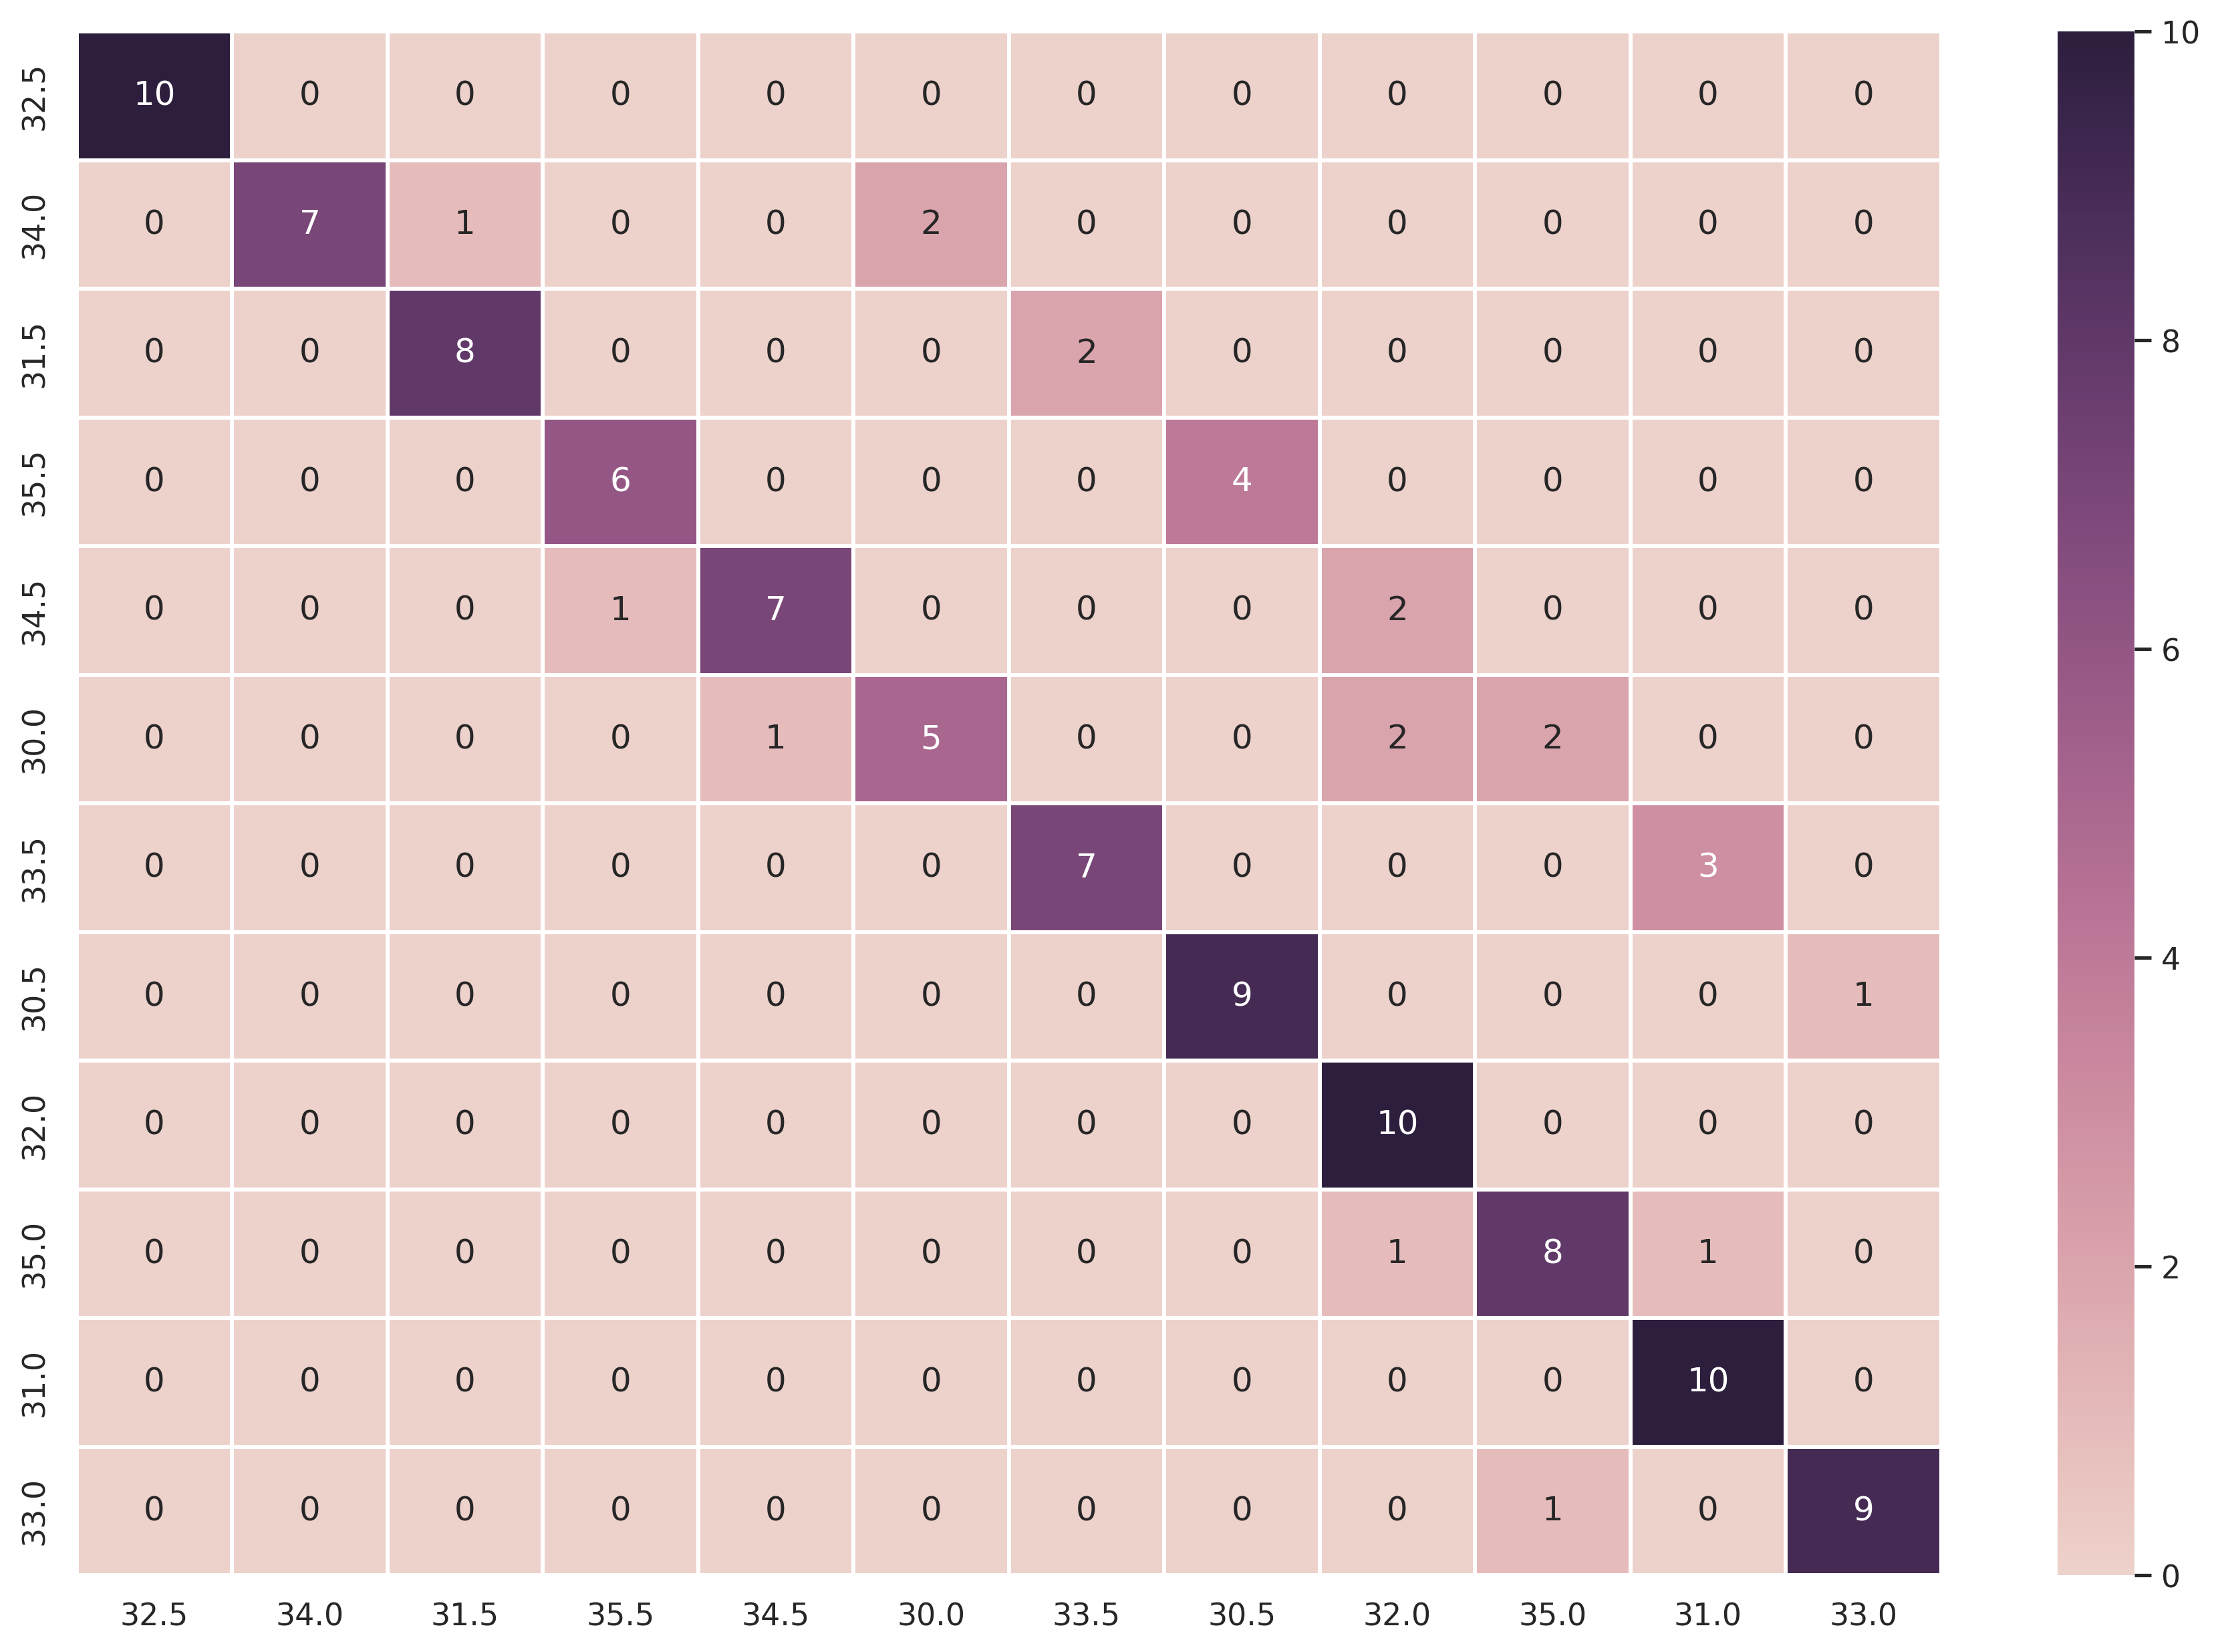

In [363]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y,y_pred)

fig, ax = plt.subplots(figsize=(15,10)) 

sns.heatmap(cf_matrix, linewidths=1, xticklabels= frequencies, yticklabels = frequencies,
 annot=True, ax=ax, fmt='g', cmap=sns.cubehelix_palette(as_cmap=True))

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
y, y_pred, Rho = results[5]["y"], results[5]["y_pred"],results[5]["Rho"]
#print(classification_report(y,y_pred))
correlation_heatmap = np.array(Rho).mean(axis=1)

fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(correlation_heatmap, linewidths=1, xticklabels= frequencies, yticklabels = frequencies, annot=True, ax=ax, fmt='g', cmap=sns.color_palette("rocket_r", as_cmap=True))

#fig.savefig(f"CCA{file_names[0]}", bbox_inches='tight')

NameError: name 'results' is not defined

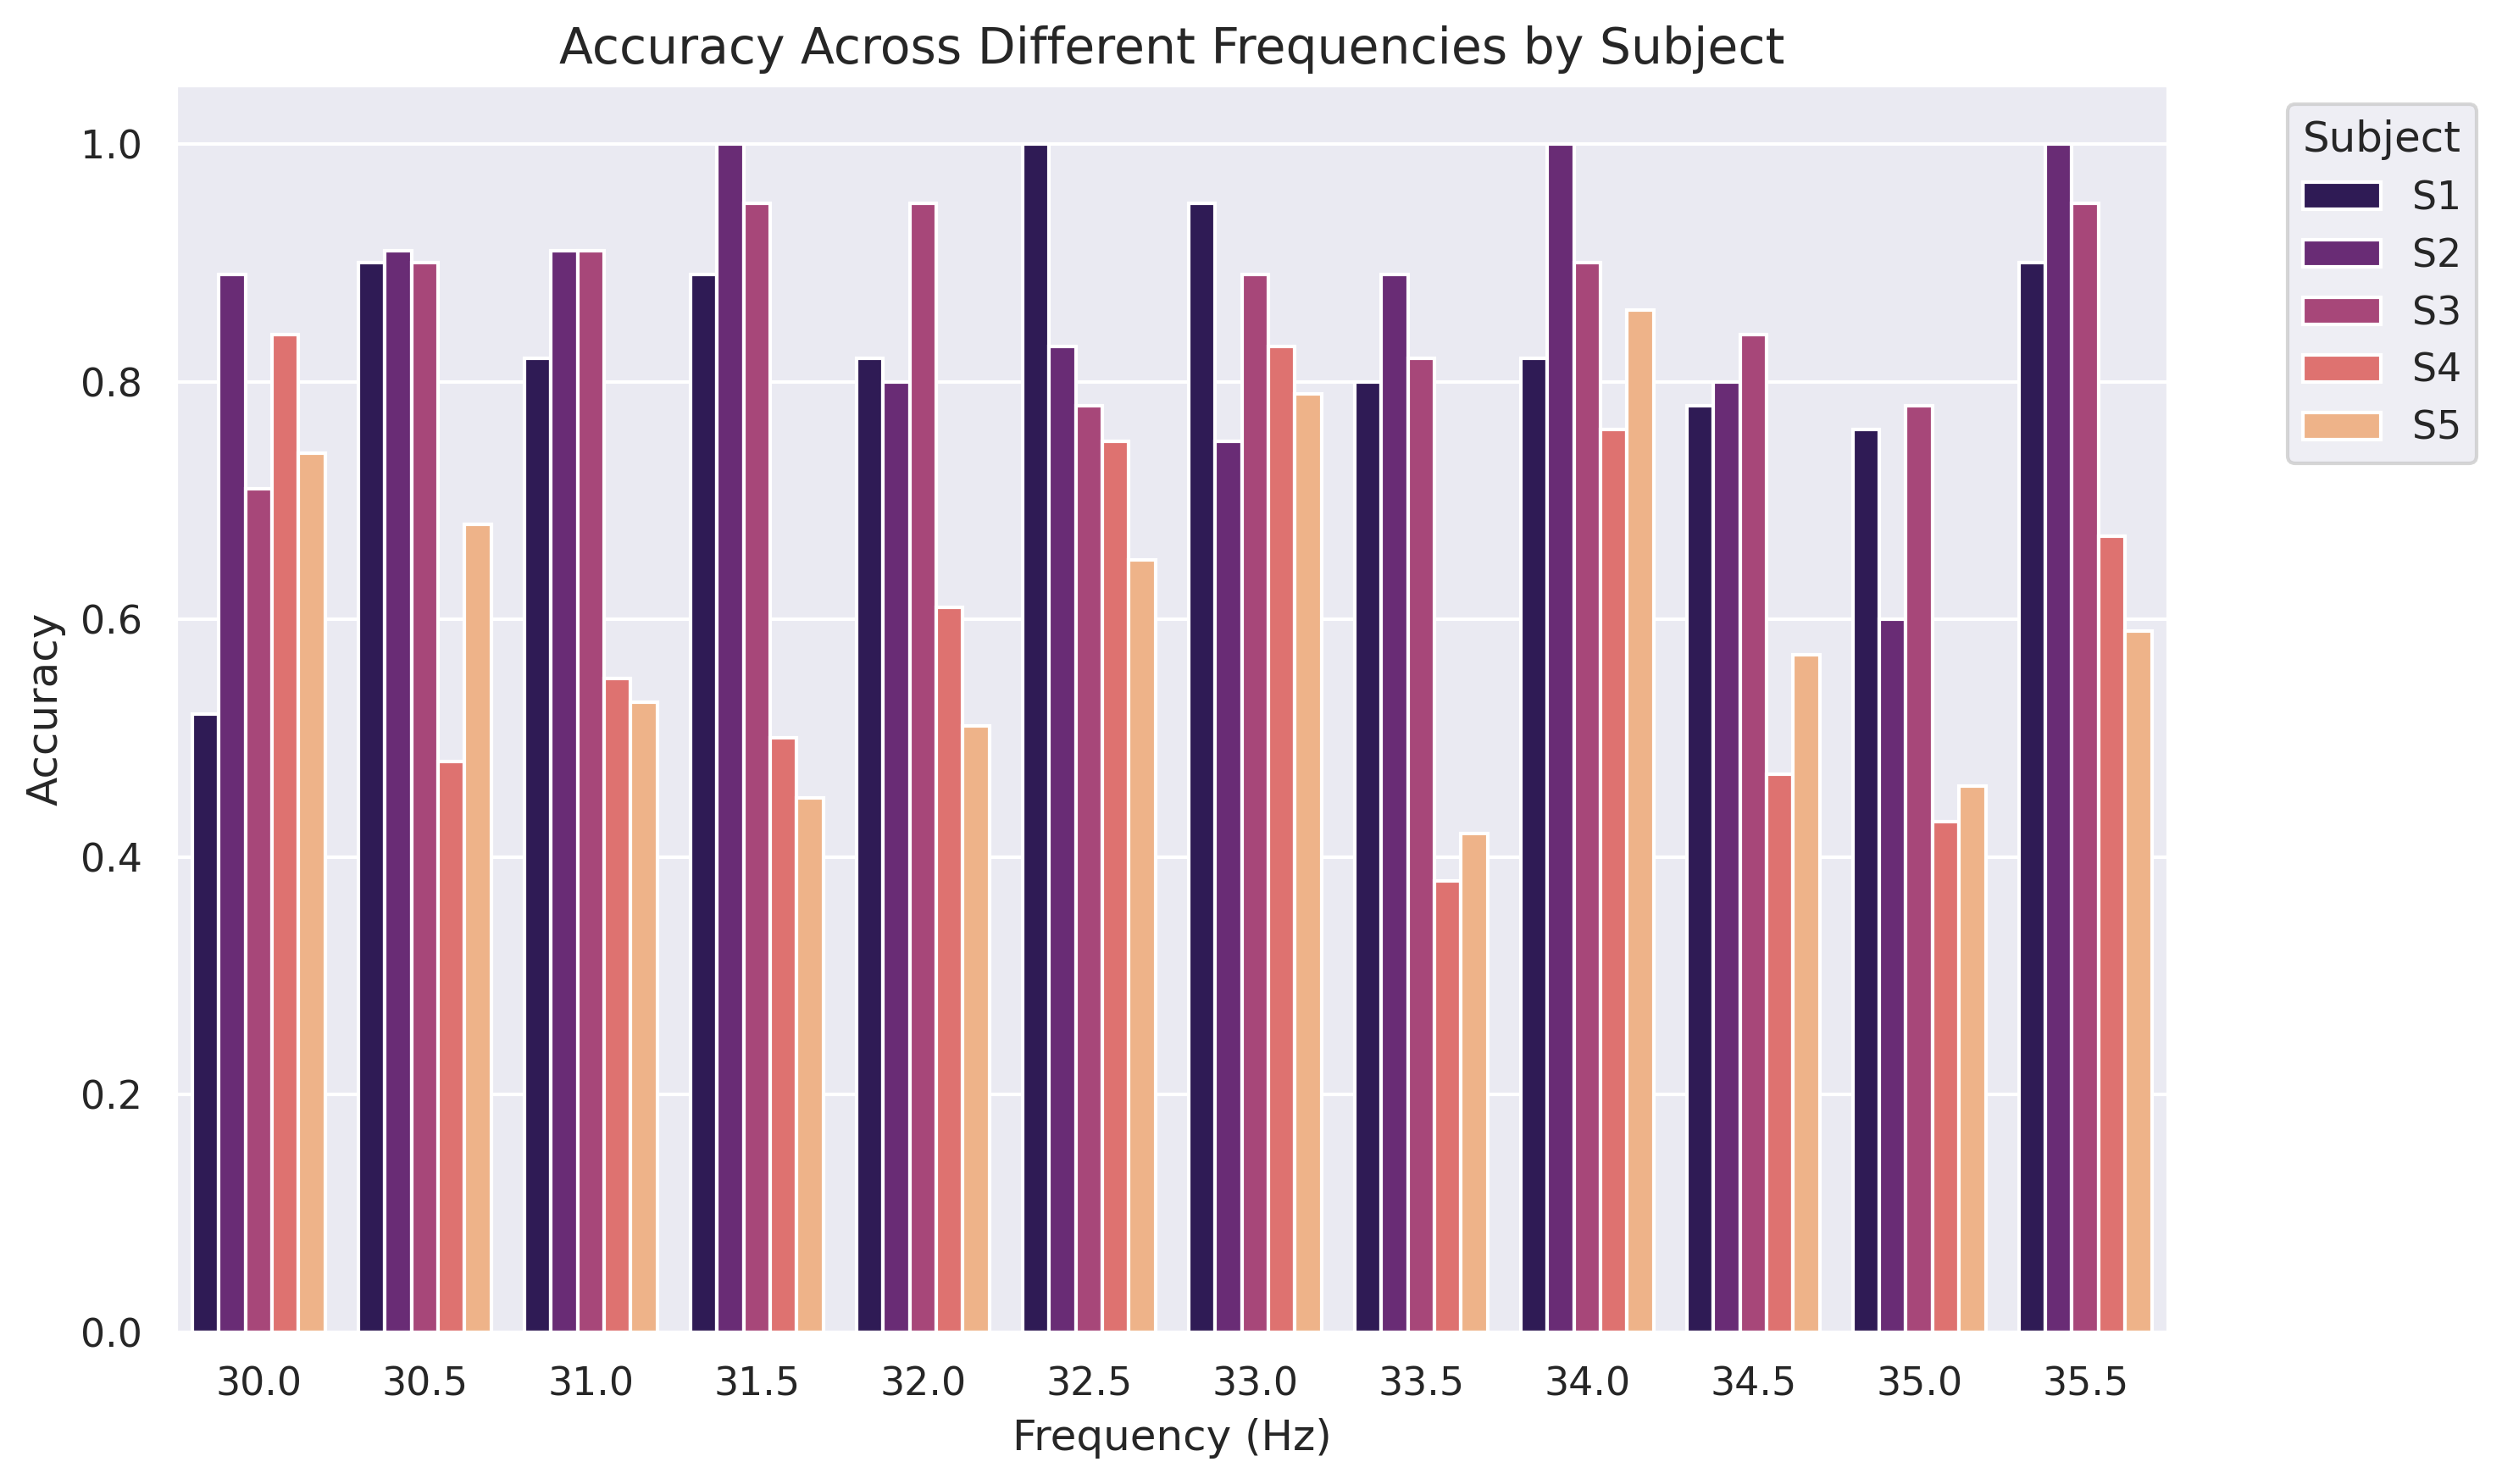

In [365]:
# Data
data = {
    'Frequency (Hz)': [32.5, 34.0, 31.5, 35.5, 34.5, 30.0, 33.5, 30.5, 32.0, 35.0, 31.0, 33.0],
    'S1': [1.00, 0.82, 0.89, 0.90, 0.78, 0.52, 0.80, 0.90, 0.82, 0.76, 0.82, 0.95],
    'S2': [0.83, 1.00, 1.00, 1.00, 0.80, 0.89, 0.89, 0.91, 0.80, 0.60, 0.91, 0.75],
    'S3': [0.78, 0.90, 0.95, 0.95, 0.84, 0.71, 0.82, 0.90, 0.95, 0.78, 0.91, 0.89],
    'S4': [0.75, 0.76, 0.50, 0.67, 0.47, 0.84, 0.38, 0.48, 0.61, 0.43, 0.55, 0.83],
    'S5': [0.65, 0.86, 0.45, 0.59, 0.57, 0.74, 0.42, 0.68, 0.51, 0.46, 0.53, 0.79]
}

# Convert the data to a DataFrame for plotting
df = pd.DataFrame(data)

# Melt the DataFrame to a long format for Seaborn
df_melted = df.melt(id_vars='Frequency (Hz)', var_name='Subject', value_name='Accuracy', )

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Frequency (Hz)', y='Accuracy', hue='Subject',  palette='magma')

# Customizing the plot
plt.title('Accuracy Across Different Frequencies by Subject', fontsize=14)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
#plt.xticks(df['Frequency (Hz)'], rotation=45)
plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(data)

df

,Frequency (Hz),SB1,SB2,SB3,SB4,SB5
0,32.5,1.00,0.83,0.78,0.75,0.65
1,34.0,0.82,1.00,0.90,0.76,0.86
2,31.5,0.89,1.00,0.95,0.50,0.45
3,35.5,0.90,1.00,0.95,0.67,0.59
4,34.5,0.78,0.80,0.84,0.47,0.57
5,30.0,0.52,0.89,0.71,0.84,0.74
6,33.5,0.80,0.89,0.82,0.38,0.42
7,30.5,0.90,0.91,0.90,0.48,0.68
8,32.0,0.82,0.80,0.95,0.61,0.51
9,35.0,0.76,0.60,0.78,0.43,0.46


In [ ]:
df_melted

,Frequency (Hz),Subject,Accuracy
0,32.5,SB1,1.00
1,34.0,SB1,0.82
2,31.5,SB1,0.89
3,35.5,SB1,0.90
4,34.5,SB1,0.78
5,30.0,SB1,0.52
6,33.5,SB1,0.80
7,30.5,SB1,0.90
8,32.0,SB1,0.82
9,35.0,SB1,0.76


/tmp/ipykernel_1377277/2460350325.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_melted, x='Subject', y='Accuracy',  palette='hls')


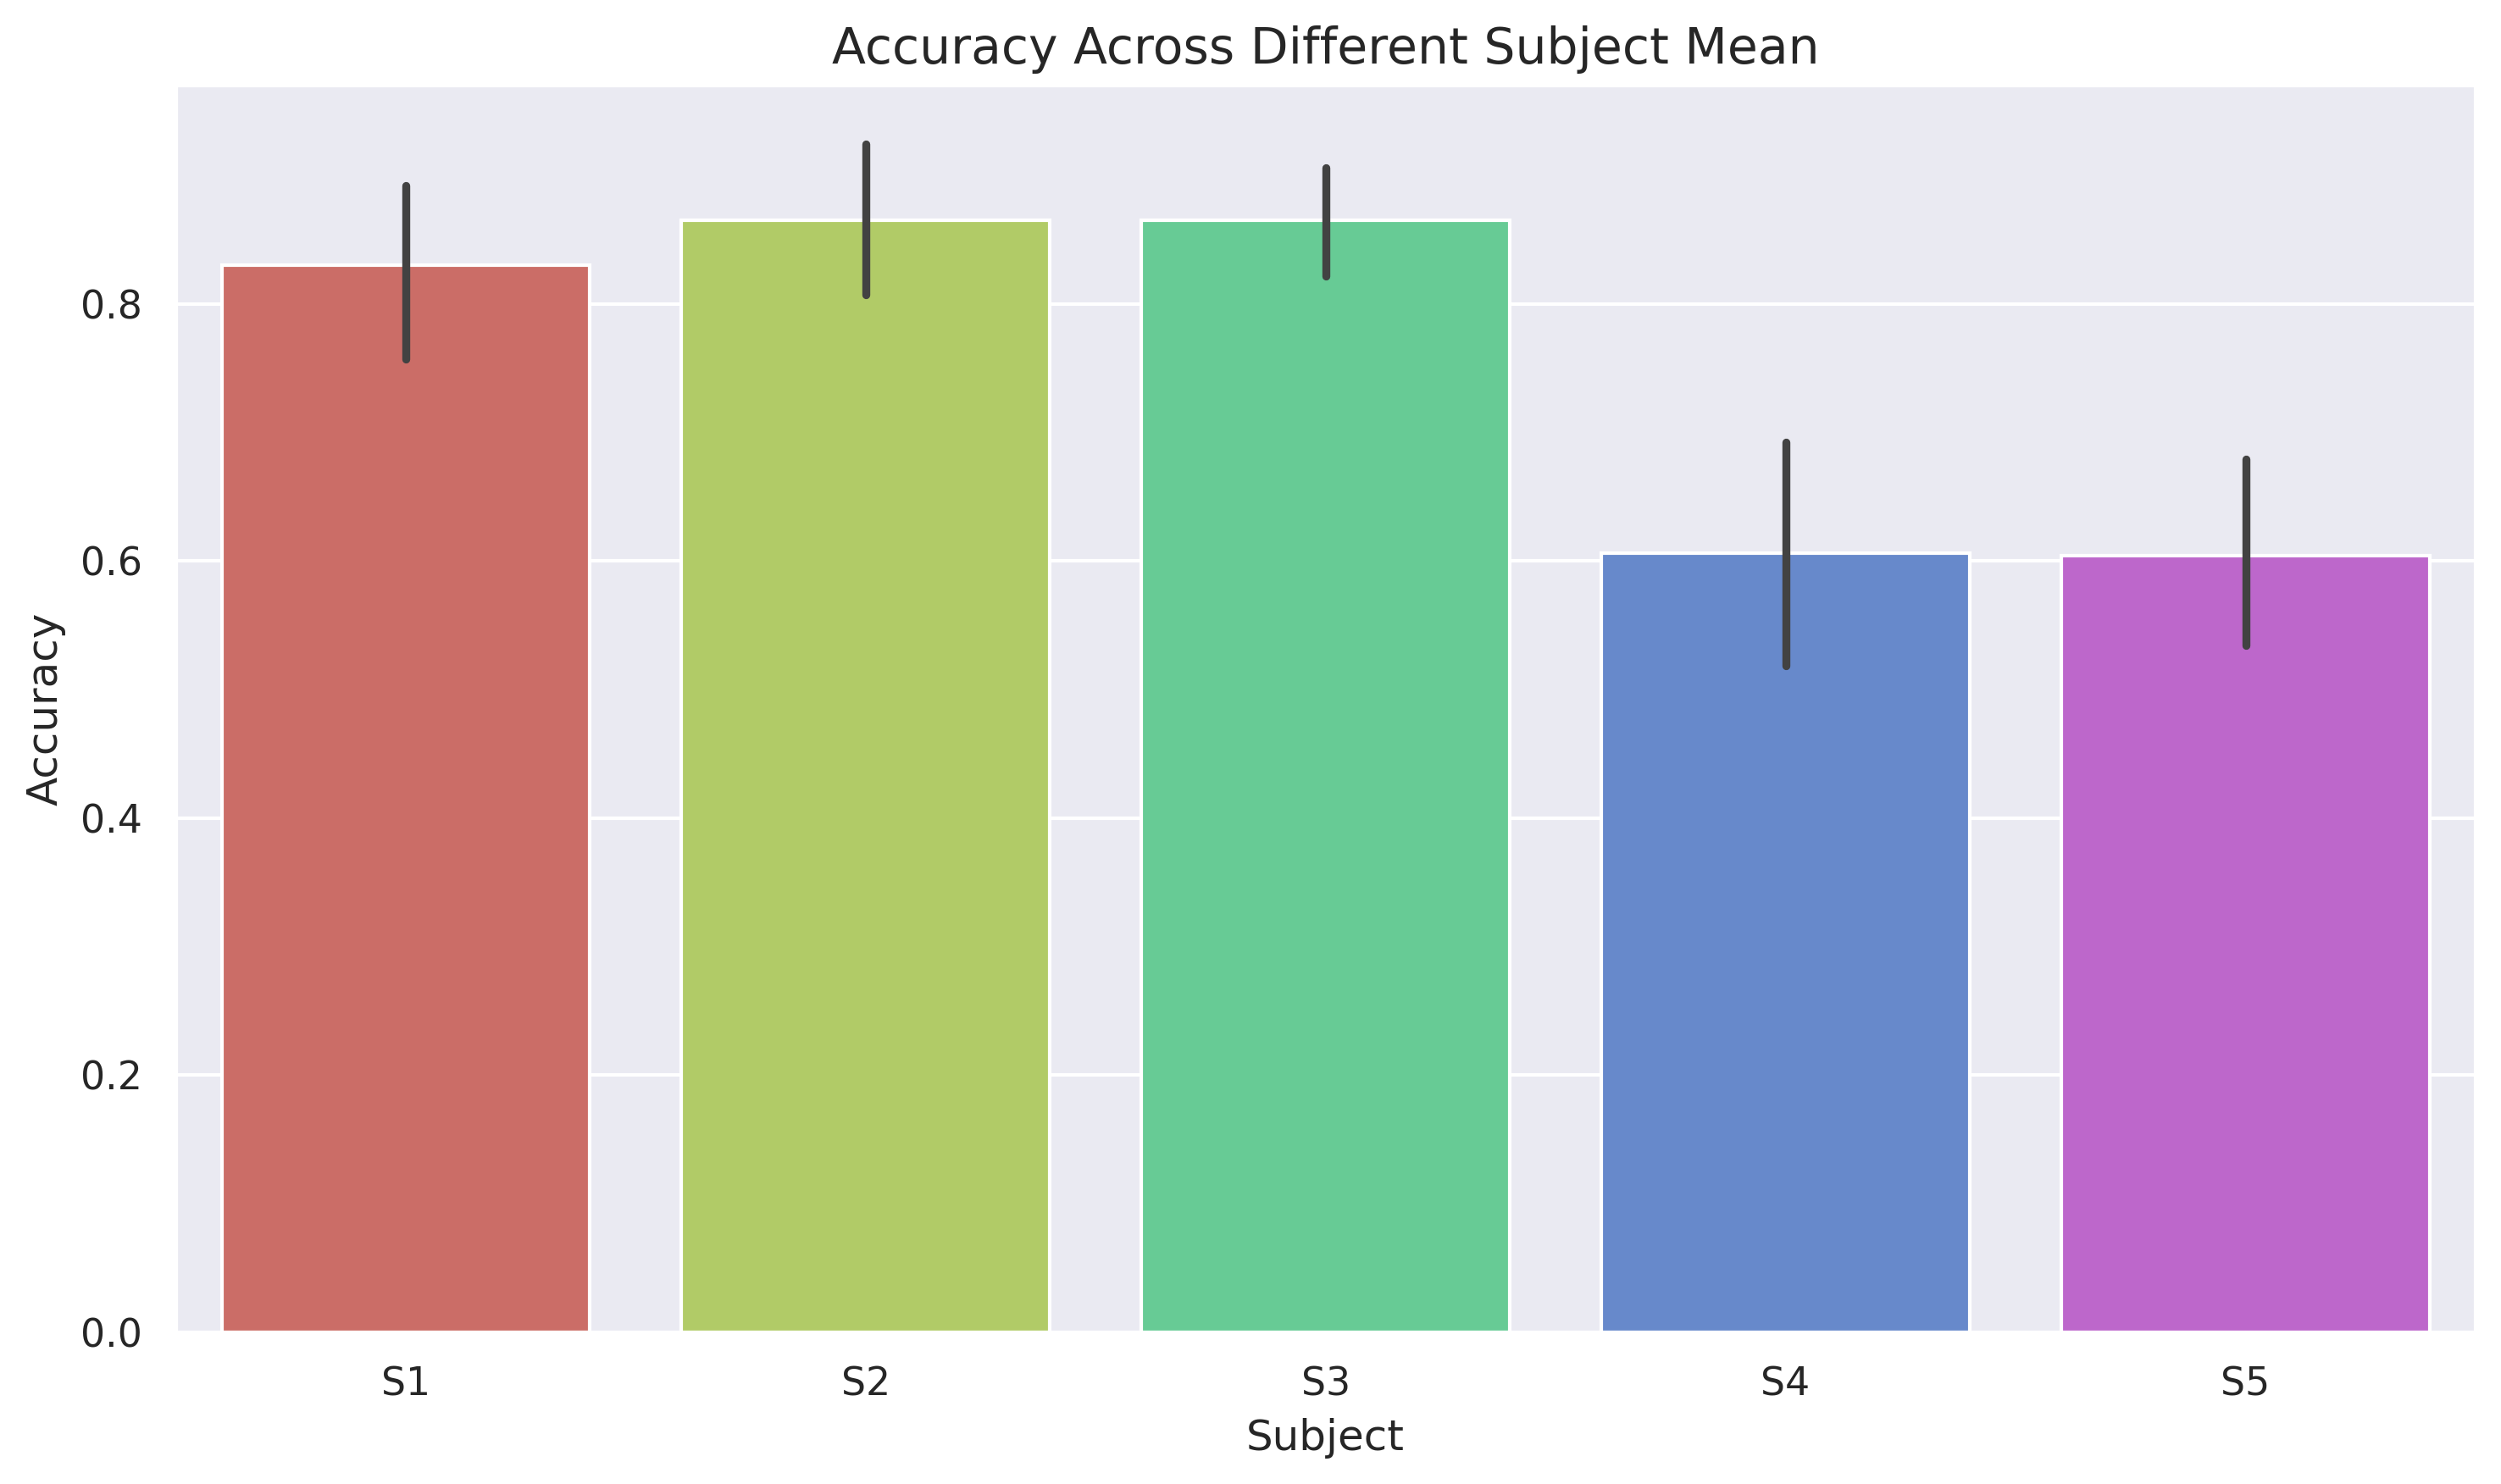

In [27]:
# Data
data = {
    'Frequency (Hz)': [32.5, 34.0, 31.5, 35.5, 34.5, 30.0, 33.5, 30.5, 32.0, 35.0, 31.0, 33.0],
    'S1': [1.00, 0.82, 0.89, 0.90, 0.78, 0.52, 0.80, 0.90, 0.82, 0.76, 0.82, 0.95],
    'S2': [0.83, 1.00, 1.00, 1.00, 0.80, 0.89, 0.89, 0.91, 0.80, 0.60, 0.91, 0.75],
    'S3': [0.78, 0.90, 0.95, 0.95, 0.84, 0.71, 0.82, 0.90, 0.95, 0.78, 0.91, 0.89],
    'S4': [0.75, 0.76, 0.50, 0.67, 0.47, 0.84, 0.38, 0.48, 0.61, 0.43, 0.55, 0.83],
    'S5': [0.65, 0.86, 0.45, 0.59, 0.57, 0.74, 0.42, 0.68, 0.51, 0.46, 0.53, 0.79]
}

# Convert the data to a DataFrame for plotting
df = pd.DataFrame(data)

# Melt the DataFrame to a long format for Seaborn
df_melted = df.melt(id_vars='Frequency (Hz)', var_name='Subject', value_name='Accuracy', )

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Subject', y='Accuracy',  palette='hls')

# Customizing the plot
plt.title('Accuracy Across Different Subject Mean', fontsize=14)
plt.xlabel('Subject', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
#plt.xticks(df['Frequency (Hz)'], rotation=45)
#plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [9]:
def prepare_csv(path, root = "./data/", delay=0, stimuli_time=5):
    df = pd.read_csv(root + path, header = None, names=["label", "timestamp"])
    #df = df[df["label"].isin(stimuli_ids )] #+ ["start", "restingCE"])]
    df["datetime"] =  pd.to_datetime(df["timestamp"], format="%Y%m%d%H%M%S%f")
    df["seconds"] = (df["datetime"] - df.iloc[0]["datetime"]).dt.total_seconds() - delay

    duration = [stimuli_time]*df.shape[0]
    #duration[0] = 2 # start 
    #duration[1] = 30 # resting state
    df["duration"] = duration

    return df



In [10]:
files = [ 'netflix_offline_3x4_jimmy.csv', 'netflix_offline_3x4_pangyu_0814.csv', 'netflix_offline_3x4_yugyeong.csv', 'arim_3x4_high.csv',
         'netflix_offline_3x4_sofia.csv', 'netflix_offline_3x4_nora.csv']

dataframes = []
for file in files:
    df = prepare_csv(file, root='/home/cnelab-workstation/jimmy/SSVEP_highfrequency/neflix_experiment/data/')
    df['source_file'] = file  # Add a column to identify the source file
    dataframes.append(df)

# Merge all dataframes into one big dataset
merged_df = pd.concat(dataframes, ignore_index=True)

# Display the merged dataframe
merged_df

,label,timestamp,datetime,seconds,duration,source_file
0,start,202408131618278429,2024-08-13 16:18:27.842900,0.0000,5,netflix_offline_3x4_jimmy.csv
1,restingCE,202408131618298421,2024-08-13 16:18:29.842100,1.9992,5,netflix_offline_3x4_jimmy.csv
2,relax,202408131618348623,2024-08-13 16:18:34.862300,7.0194,5,netflix_offline_3x4_jimmy.csv
3,start_9,202408131618418586,2024-08-13 16:18:41.858600,14.0157,5,netflix_offline_3x4_jimmy.csv
4,9,202408131618444632,2024-08-13 16:18:44.463200,16.6203,5,netflix_offline_3x4_jimmy.csv
...,...,...,...,...,...,...
2167,start_3,202407311435222174,2024-07-31 14:35:22.217400,1373.6539,5,netflix_offline_3x4_nora.csv
2168,3,202407311435229601,2024-07-31 14:35:22.960100,1374.3966,5,netflix_offline_3x4_nora.csv
2169,relax,202407311435279919,2024-07-31 14:35:27.991900,1379.4284,5,netflix_offline_3x4_nora.csv
2170,start_7,202407311435329769,2024-07-31 14:35:32.976900,1384.4134,5,netflix_offline_3x4_nora.csv


In [11]:
# Function to split the label
def split_label(label):
    if 'start_' in label:
        return label.split('_', 1)[1], label  # returns (number, original_label)
    else:
        return None, label  # returns (None, label) for non-start labels

## Dwell

In [12]:
start_label = [f"start_{label}" for label in range(12)]

push_label = [f"{label}" for label in range(12)]

In [13]:
from datetime import datetime

time_data = merged_df[merged_df["label"].isin(push_label)].reset_index()


time_data["dwell"] = (time_data.datetime - merged_df[merged_df["label"].isin(start_label)].reset_index().datetime ).dt.total_seconds() 

In [14]:
mapping_idx_freq = dict(zip([f"{i}" for i in range(12)], [f"{f}" for f in frequencies]))

time_data.replace({"label" : mapping_idx_freq}, inplace=True)

/tmp/ipykernel_1342381/3373409190.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(time_data, x="label", y="dwell", palette='hls', native_scale=True, order = [f"{f}" for f in frequencies])


[(0.0, 4.6), Text(0.5, 0, 'Stimuli Frequency'), Text(0, 0.5, 'dwell time (s)')]

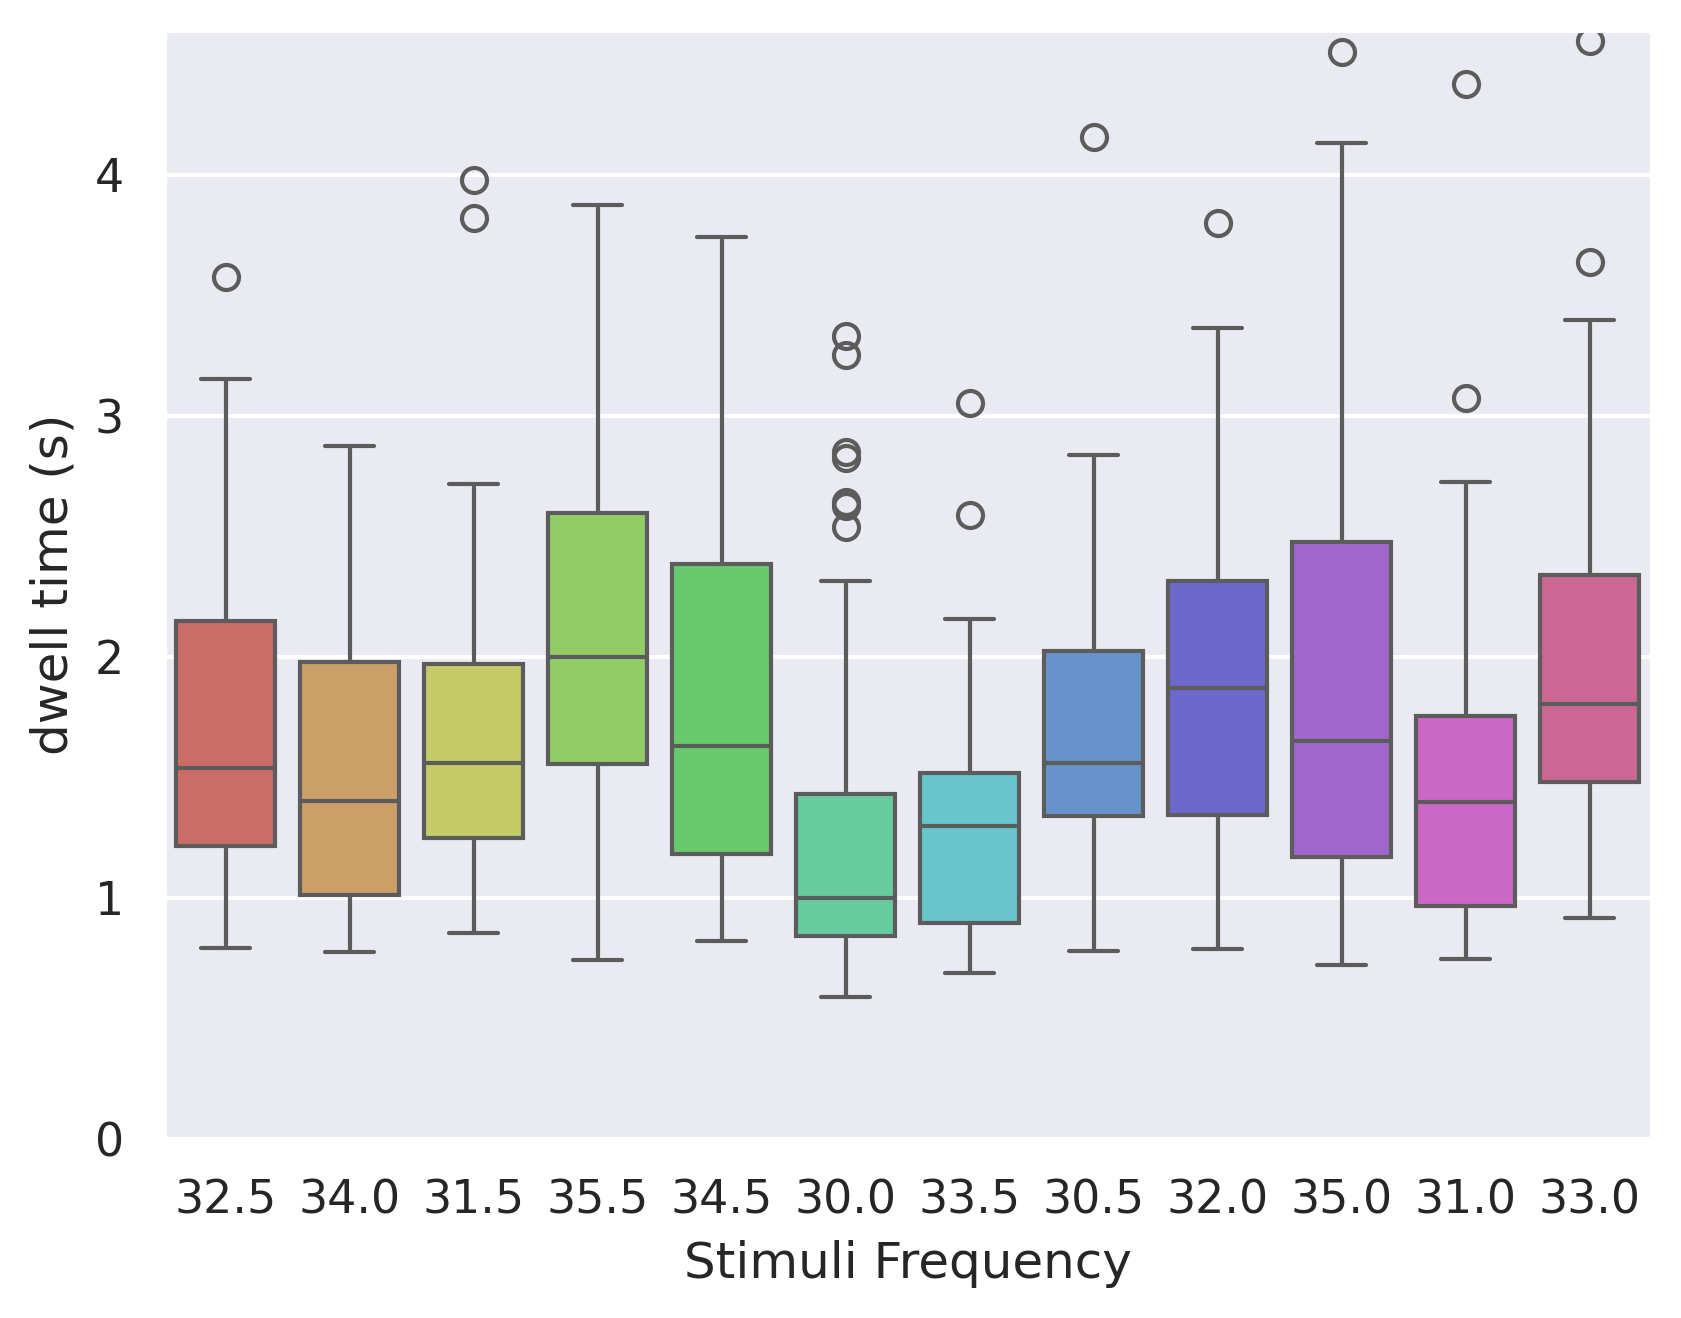

In [17]:
sns.set_theme(rc={"figure.dpi": 300})

ax = sns.boxplot(time_data, x="label", y="dwell", palette='hls', native_scale=True, order = [f"{f}" for f in frequencies])

ax.set(ylim=(0, 4.6), xlabel="Stimuli Frequency", ylabel="dwell time (s)")


In [20]:
time_data.describe()

,index,timestamp,datetime,seconds,duration,dwell
count,720.000000,7.200000e+02,720,720.000000,720.0,720.000000
mean,1087.500000,2.024079e+17,2024-08-10 06:58:26.517890304,834.755007,5.0,1.800984
min,4.000000,2.024073e+17,2024-07-31 14:12:41.503100,12.939600,5.0,0.588600
25%,545.250000,2.024073e+17,2024-07-31 17:49:56.533999872,430.251225,5.0,1.155550
50%,1087.500000,2.024081e+17,2024-08-08 01:42:39.492900096,830.469300,5.0,1.545750
75%,1629.750000,2.024081e+17,2024-08-14 16:01:01.378200064,1229.150125,5.0,2.122125
max,2171.000000,2.024083e+17,2024-08-29 14:23:09.719500,1756.510200,5.0,12.964000
std,627.341633,4.015757e+11,NaN,472.684026,0.0,1.152681


In [354]:
time_data.groupby("label")[["dwell"]].describe()

dwell                                                                  
      count      mean       std     min       25%      50%       75%      max
label                                                                        
30.0   60.0  1.297723  0.696063  0.5886  0.840400  1.00055  1.430625   3.3284
30.5   60.0  1.842987  1.201753  0.7770  1.340075  1.55700  2.025100   9.6903
31.0   60.0  1.543977  0.880105  0.7439  0.963975  1.39585  1.754350   6.0110
31.5   60.0  1.667805  0.606082  0.8540  1.248850  1.55790  1.968175   3.9755
32.0   60.0  2.003832  1.090485  0.7872  1.341575  1.87025  2.314050   8.3744
32.5   60.0  1.708550  0.672012  0.7921  1.212650  1.53995  2.146175   3.5739
33.0   60.0  2.159820  1.355890  0.9172  1.480225  1.80410  2.338250   9.5169
33.5   60.0  1.443995  0.986255  0.6887  0.894025  1.29620  1.516150   6.4473
34.0   60.0  1.685938  1.109627  0.7768  1.013250  1.40080  1.978525   7.6412
34.5   60.0  1.819982  0.814223  0.8221  1.179375  1.63090  2.383975   4.8870
35.0   60.0  2.216702  2.061918  0.7211  1.167525  1.65020  2.474925  12.9640
35.5   60.0  2.220495  1.224468  0.7427  1.555200  1.99795  2.594400   9.8559

In [27]:
values = [0.83, 0.87, 0.86, 0.62, 0.60]

# Calculating the average
average_value = sum(values) / len(values)
average_value

0.756

In [31]:
import pandas as pd 
import seaborn as sns
data = {
    "Subject": ["S1", "S2", "S3", "S4", "S5"],
    "ITR": [ 26.05, 28.3, 30.69, 14.36, 12.21],
    "Type": ["ITR","ITR","ITR","ITR","ITR"]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

  Subject    ITR Type
0      S1  26.05  ITR
1      S2  28.30  ITR
2      S3  30.69  ITR
3      S4  14.36  ITR
4      S5  12.21  ITR


In [25]:
plt.figure(figsize=(10, 6))
sns.set_theme(rc={"figure.dpi": 300})
ax = sns.barplot(data=df, x='Subject', y='ITR', palette='hls')
plt.title('ITR Across Different Subject Mean', fontsize=14)


NameError: name 'plt' is not defined